In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from scipy import sparse
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers
# from sklearn.metrics import f1_score
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression, ElasticNet

In [2]:
%cd drive/MyDrive/MUSAE_GIT/
%ls

/content/drive/MyDrive/MUSAE_GIT
musae_git_edges.csv  musae_git_features.csv  musae_git_target.csv


In [3]:
target = pd.read_csv("musae_git_target.csv")
features = pd.read_csv("musae_git_features.csv")
edges = pd.read_csv("musae_git_edges.csv")

In [4]:
edges.rename(columns={"id_1": "source", "id_2": "target"}, inplace=True )
edges.sample(frac=1).head()

,source,target
281660,24390,34536
4240,36681,907
169391,13638,34909
243737,23398,20816
247382,23973,31197


In [5]:
print(target.shape)
print(features.shape)
print(edges.shape)

(37700, 3)
(690374, 2)
(289003, 2)


In [6]:
def transform_features_to_sparse(table):
    table["weight"] = 1
    table = table.values.tolist()
    index_1 = [row[0] for row in table]
    index_2 =  [row[1] for row in table]
    values =  [row[2] for row in table] 
    count_1, count_2 = max(index_1)+1, max(index_2)+1
    sp_m = sparse.csr_matrix(sparse.coo_matrix((values,(index_1,index_2)),shape=(count_1,count_2),dtype=np.float32))
    return sp_m

In [7]:
X = transform_features_to_sparse(features)
model = TruncatedSVD(n_components=16, random_state=0)
features_new = model.fit_transform(X)

In [8]:
features

,node,feature,weight
0,0,1574,1
1,0,3773,1
2,0,3571,1
3,0,2672,1
4,0,2478,1
...,...,...,...
690369,37699,1764,1
690370,37699,3771,1
690371,37699,234,1
690372,37699,968,1


In [9]:
X

<37700x4005 sparse matrix of type '<class 'numpy.float32'>'
	with 690358 stored elements in Compressed Sparse Row format>

In [10]:
features_new.shape

(37700, 16)

In [11]:
features = pd.DataFrame(features_new, columns = ["feature_"+str(i) for i in range(features_new.shape[1])])

In [12]:
features["Target"] = np.array(target["ml_target"])
features['id'] = np.array([i for i in range(len(features))])


In [13]:
print(features.Target.value_counts())

0    27961
1     9739
Name: Target, dtype: int64


In [14]:
class_values = sorted(features["Target"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(features["id"].unique()))}

features["id"] = features["id"].apply(lambda name: paper_idx[name])
edges["source"] = edges["source"].apply(lambda name: paper_idx[name])
edges["target"] = edges["target"].apply(lambda name: paper_idx[name])
features["Target"] = features["Target"].apply(lambda value: class_idx[value])

In [15]:
features

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,Target,id
0,1.939631,-0.694611,0.872876,-0.419279,0.560546,-0.566410,0.738883,-0.652300,0.228275,-0.194265,0.849285,0.407779,0.166921,0.143372,0.072993,-0.012849,0,0
1,2.611609,-0.607271,-0.687596,0.046130,-0.065245,0.011044,0.380156,-0.016371,0.699392,-0.217228,0.825244,-0.193476,0.954436,-0.087281,0.259005,0.132162,0,1
2,1.837480,-0.809220,1.029143,-0.032218,-0.075327,-0.470448,-0.381871,0.052617,-0.920271,0.096616,0.525174,-0.629725,-0.134108,0.241310,-0.239324,0.064351,1,2
3,2.270206,0.605448,0.513798,-0.147808,-0.411829,-0.057815,0.361992,0.682248,-0.049878,0.500953,-0.734310,0.332842,-0.536311,-0.622356,0.237817,0.317030,0,3
4,2.886448,0.748215,0.886577,0.257921,0.249861,-0.586973,0.333146,-0.208066,0.300091,0.570674,0.627631,-0.349942,0.034833,0.623477,-0.639018,-0.115979,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37695,2.355479,0.461217,0.953078,-0.720586,-1.082185,-0.186885,0.505461,-0.425248,-0.085131,-0.670046,0.254418,0.943904,0.426728,-0.421284,1.013907,-0.457084,1,37695
37696,2.714246,-0.568275,0.488237,-0.747781,0.807977,-0.570315,-0.477595,0.185557,-0.909409,-0.351813,-0.088452,0.033644,0.260954,-0.035890,-1.089329,-0.060143,0,37696
37697,2.842416,-0.580293,0.231513,-0.088957,0.703775,0.553296,0.354288,-0.603718,-0.473114,0.058490,0.085256,0.799372,-0.385737,-0.228912,0.387926,0.151733,0,37697
37698,2.675977,-0.757174,0.408821,0.067852,-0.148809,0.791155,-0.777882,0.650789,-0.343619,-0.097027,-0.057923,-0.221984,-0.390262,-0.148511,-0.115997,-0.161466,1,37698


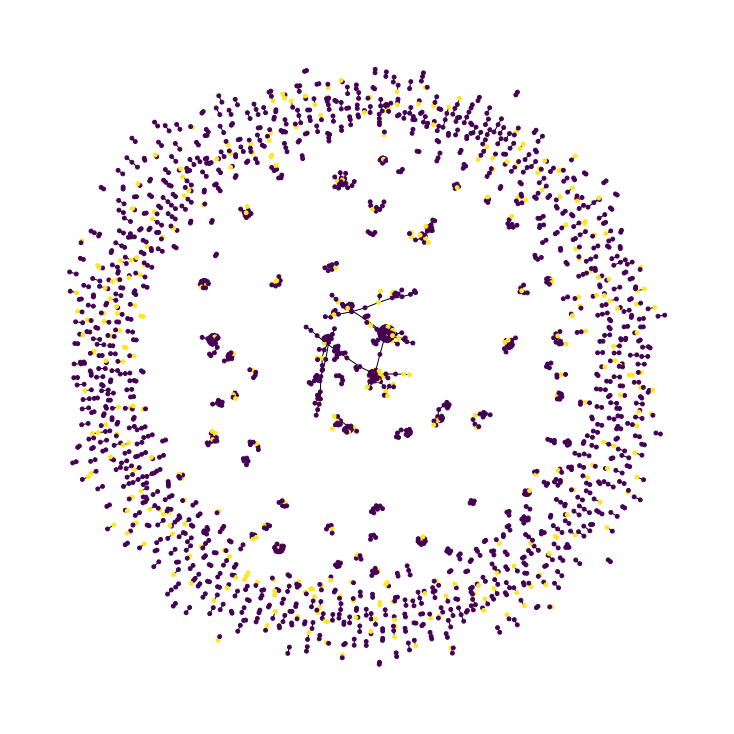

In [16]:
plt.figure(figsize=(10, 10))
colors = features["Target"].tolist()
cora_graph = nx.from_pandas_edgelist(edges.sample(n=1500))
subjects = list(features[features["id"].isin(list(cora_graph.nodes))]["Target"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

In [17]:
train_data, test_data = [], []

for _, group_data in features.groupby("Target"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (18874, 18)
Test data shape: (18826, 18)


In [18]:

def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [19]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [20]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [21]:
features.columns

Index(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'Target', 'id'],
      dtype='object')

In [22]:
feature_names = set(features.columns) - {"id","Target"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data['Target']
y_test = test_data['Target']

In [23]:
x_test

array([[ 0.4191485 ,  0.13307145,  0.78121984, ..., -0.04257186,
        -0.63565105,  0.32152784],
       [-0.01201946,  0.15286553,  0.91875625, ..., -0.58491266,
        -0.542896  , -0.7864829 ],
       [ 0.14427017, -0.08544555, -0.15045422, ..., -0.07678303,
        -0.04380161, -0.17716518],
       ...,
       [ 0.03033727, -0.06328201, -0.31723526, ..., -0.16695912,
         0.8328853 ,  0.25109717],
       [ 0.29956228,  0.64444727,  0.16366296, ...,  0.16621436,
        -0.2694267 ,  0.3073304 ],
       [ 0.08220233, -0.8993042 , -0.47206208, ..., -0.75584984,
        -0.44212422,  0.17494579]], dtype=float32)

In [25]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.2
num_epochs = 30
batch_size = 64

In [26]:

from keras import layers
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 16)]         0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           1792        ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [27]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = edges[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    features.sort_values("id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 289003)
Nodes shape: (37700, 16)


In [28]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat", #update
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[1], edges[0]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


In [31]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )

        # Create the third GraphConv layer.
        self.conv3 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv3",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Apply the second graph conv layer.
        x3 = self.conv3((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x3 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [32]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[-0.00120238 -0.07191889]
 [ 0.03503421 -0.23602119]
 [-0.07110532 -0.18994492]], shape=(3, 2), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (37700, 32)               1792      
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv3 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                

In [33]:
x_train = train_data.id.to_numpy()
len(x_train)

18874

In [34]:
y_train

30680    0
1639     0
28674    1
15263    1
1498     1
        ..
22582    0
24070    0
12150    1
28931    0
37239    1
Name: Target, Length: 18874, dtype: int64

In [35]:
x_train = train_data.id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/30
251/251 [==============================] - 38s 127ms/step - loss: 0.5562 - acc: 0.7470 - val_loss: 0.4024 - val_acc: 0.8347
Epoch 2/30
251/251 [==============================] - 32s 126ms/step - loss: 0.5079 - acc: 0.7764 - val_loss: 0.4414 - val_acc: 0.8291
Epoch 3/30
251/251 [==============================] - 31s 124ms/step - loss: 0.4932 - acc: 0.7832 - val_loss: 0.4170 - val_acc: 0.8355
Epoch 4/30
251/251 [==============================] - 31s 125ms/step - loss: 0.4680 - acc: 0.7963 - val_loss: 0.4296 - val_acc: 0.8390
Epoch 5/30
251/251 [==============================] - 31s 125ms/step - loss: 0.4617 - acc: 0.8012 - val_loss: 0.4163 - val_acc: 0.8347
Epoch 6/30
251/251 [==============================] - 33s 130ms/step - loss: 0.4500 - acc: 0.8082 - val_loss: 0.4192 - val_acc: 0.8337
Epoch 7/30
251/251 [==============================] - 31s 125ms/step - loss: 0.4445 - acc: 0.8102 - val_loss: 0.4067 - val_acc: 0.8369
Epoch 8/30
251/251 [==============================] - 3

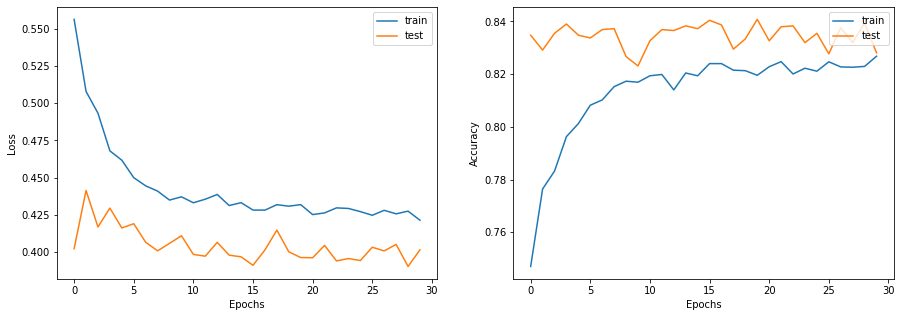

In [36]:
display_learning_curves(history)

In [37]:
x_test = test_data.id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 83.71%
